In [1]:
from tqdm import tqdm
import os
import argparse
import requests
from zipfile import ZipFile
import os

The propecssing part is the same as the basic unet

In [2]:
def clear_screen():
    """Clears the console screen irrespective of os used"""
    import platform
    if platform.system() == 'Windows':
        os.system('cls')
        return
    os.system('clear')

In [3]:
def unzip_file(source_name, destination):
    """ Unizips a zip file and stores the contents in destination folder.
    Parameters:
        source_name(str): Full path of the source path
        destination(str): Full folder path where contents of source_name will be stored.

    Returns: None
    """
    with ZipFile(source_name, 'r') as zipfile:
        # extracting all the files
        print(f'\tExtracting files of {source_name}')
        zipfile.extractall(destination)
        print(f'\tDone with {source_name}')
        
def make_folder(target_folder):
    """Creates folder if there is no folder in the specified path.
    Parameters: 
        target_folder(str): path of the folder which needs to be created.

    Returns: None
    """
    if not (os.path.isdir(target_folder)):
        print(f'Creating {target_folder} folder')
        os.mkdir(target_folder)



In [4]:
def main():
    # Clears the screen.
    clear_screen()

    # File names in a list.
    file_names = [
        f'stage1_train.zip' ]

    # Destination folder to store files.
    destination = os.path.join('dataset', 'stage1_train')
    # Make the destination folder.
    make_folder(os.path.join('dataset', 'stage1_train'))

    for file in file_names:
        path = os.path.join('dataset', file)
        unzip_file(path, destination)

if __name__ == "__main__":
    main()

	Extracting files of dataset/stage1_train.zip
	Done with dataset/stage1_train.zip


In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import os
import random
import shutil
from shutil import copy2
trainfiles = os.listdir('./dataset/stage1_train')
num_train = len(trainfiles)
#print( "num_train: " + str(num_train) )
index_list = list(range(num_train))
#print(index_list)
random.shuffle(index_list)
num = 0
trainDir = './dataset/train'
testDir = './dataset/test'
for i in index_list:
    fileName = os.path.join('./dataset/stage1_train', trainfiles[i])
    if num < num_train*0.9:
        #print(str(fileName))
        shutil.move(fileName,trainDir)
    else:
        shutil.move(fileName,testDir)
    num += 1


Error: Destination path './dataset/train/9facc652efe19f634639585d692a53dd6c2a8e2f0c9baebdfd85b9b41ec58851' already exists

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './dataset/train/'
TEST_PATH = './dataset/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 46
random.seed = seed
np.random.seed = seed

In [4]:

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 604/604 [05:01<00:00,  2.00it/s]


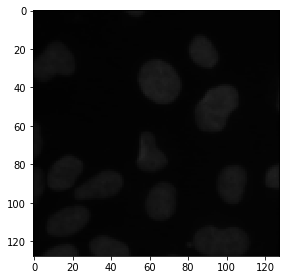

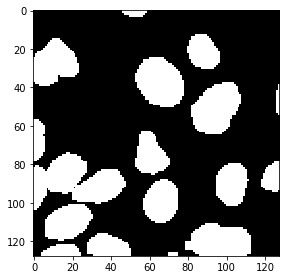

In [6]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [27]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply
from keras.layers import concatenate, core, Dropout
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as keras
import tensorflow as tf
from keras import models, layers, regularizers
from keras import backend as K



# input data
INPUT_SIZE = 128
INPUT_CHANNEL = 3   # 1-grayscale, 3-RGB scale
OUTPUT_MASK_CHANNEL = 1
# network structure
FILTER_NUM = 32 # number of basic filters for the first layer
FILTER_SIZE = 3 # size of the convolutional filter
DOWN_SAMP_SIZE = 2 # size of pooling filters
UP_SAMP_SIZE = 2 # size of upsampling filters

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
smooth = 1.

# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [28]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def expend_as(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    '''
    construction of a double convolutional layer using
    SAME padding
    RELU nonlinear activation function
    :param x: input
    :param filter_size: size of convolutional filter
    :param size: number of filters
    :param dropout: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: output of a double convolutional layer
    '''
    axis = 3
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=axis)(shortcut)

    res_path = layers.add([shortcut, conv])
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :param input:   down-dim feature map
    :param out_size:output channel number
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn
def Attention_ResUNet(dropout_rate=0.2, batch_norm=True):
    '''
    Rsidual UNet construction, with attention gate
    convolution: 3*3 SAME padding
    pooling: 2*2 VALID padding
    upsampling: 3*3 VALID padding
    final convolution: 1*1
    :param dropout_rate: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: model
    '''
    # input data
    # dimension of the image depth
    inputs = layers.Input((INPUT_SIZE, INPUT_SIZE, INPUT_CHANNEL))
    s = Lambda(lambda x: x / 255) (inputs)
    axis = 3
    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    dropout_rate = 0
    batch_norm = True
    conv_128 = double_conv_layer(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = double_conv_layer(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = double_conv_layer(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = double_conv_layer(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = double_conv_layer(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # valid padding
    # batch normalization
    # sigmoid nonlinear activation
    conv_final = layers.Conv2D(OUTPUT_MASK_CHANNEL, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('relu')(conv_final)
    
    model = Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam',loss='mean_squared_logarithmic_error', metrics=[dice_coef])


    # Model integration
   
    return model


I changed the checkpoint name to distinguish with the basic unet. But the other code is the same. So I didn't rerun the while code.

In [29]:
earlystopper = EarlyStopping(patience=5, verbose=1)
#keras.callbacks.LearningRateScheduler(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
checkpointer = ModelCheckpoint('advanced.h5', verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, mode='auto')
# get u_net model
model = Attention_ResUNet()

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs=50, 
                     callbacks=[reduce_lr,earlystopper, checkpointer])

Train on 543 samples, validate on 61 samples
Epoch 1/50
543/543 [==============================] - 313s 576ms/step - loss: 0.0434 - dice_coef: 0.6727 - val_loss: 0.0933 - val_dice_coef: 0.0948

Epoch 00001: val_loss improved from inf to 0.09327, saving model to model-dsbowl2018-1.h5
Epoch 2/50
543/543 [==============================] - 267s 492ms/step - loss: 0.0204 - dice_coef: 0.8148 - val_loss: 0.0472 - val_dice_coef: 0.4901

Epoch 00002: val_loss improved from 0.09327 to 0.04716, saving model to model-dsbowl2018-1.h5
Epoch 3/50
543/543 [==============================] - 267s 492ms/step - loss: 0.0210 - dice_coef: 0.8069 - val_loss: 0.0242 - val_dice_coef: 0.7140

Epoch 00003: val_loss improved from 0.04716 to 0.02421, saving model to model-dsbowl2018-1.h5
Epoch 4/50
543/543 [==============================] - 267s 491ms/step - loss: 0.0160 - dice_coef: 0.8407 - val_loss: 0.0812 - val_dice_coef: 0.5530

Epoch 00004: val_loss did not improve from 0.02421
Epoch 5/50
543/543 [==========

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 128, 128, 32) 128         conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 128, 32) 0           batch_normalization_40[0][0]     
____________________________________________________________________________________________

In [12]:
# Get and resize test images and masks
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 67/67 [00:30<00:00,  2.21it/s]


In [13]:
model = load_model('advanced.h5', custom_objects={'dice_coef': dice_coef})
model.evaluate(X_test, Y_test, batch_size=1, verbose=0, sample_weight=None, steps=None)

[0.011385029884673822, 0.871531069278717]

In [14]:
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

67/67 [==============================] - 11s 169ms/step


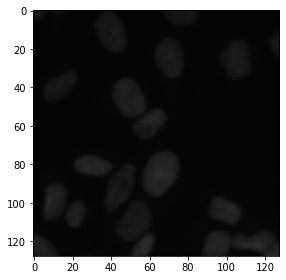

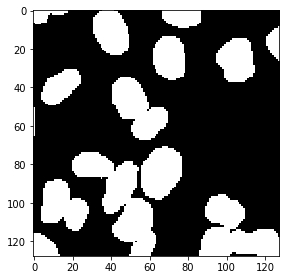

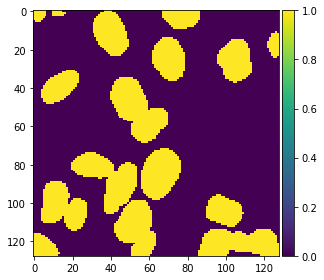

In [15]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix]/255)
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [16]:
from PIL import Image
TEST_PATH2 = './dataset2/image/'
test_ids2 = next(os.walk(TEST_PATH2))[2]
d2_train = np.zeros((len(test_ids2), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
print(len(test_ids2))
for n, id_ in tqdm(enumerate(test_ids2), total=len(test_ids2)):
    path = TEST_PATH2
    img = Image.open(path  + id_ )
    img = img.convert('RGB')
    img = np.array(img) 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    d2_train[n] = img

Getting and resizing train images and masks ... 


 33%|███▎      | 2/6 [00:00<00:00, 15.13it/s]

6


100%|██████████| 6/6 [00:00<00:00, 21.75it/s]


In [25]:
model = load_model('advanced.h5', custom_objects={'dice_coef': dice_coef})

preds_test2 = model.predict(d2_train, verbose=1)

# Threshold predictions
preds_test_t2 = (preds_test2 > 0.5).astype(np.uint8)

6/6 [==============================] - 8s 1s/step


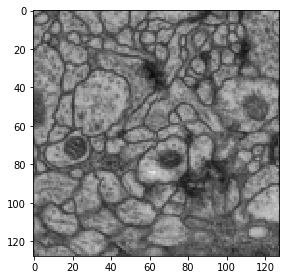

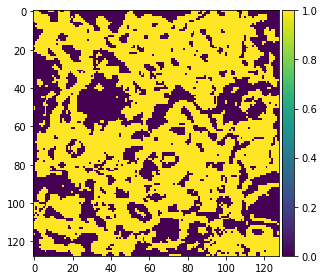

In [26]:
ix = random.randint(0, len(preds_test_t2))
imshow(d2_train[3])
plt.show()
imshow(np.squeeze(preds_test_t2[3]))
plt.show()